<a href="https://colab.research.google.com/github/rahul94jh/MSC-Research/blob/main/clickbait_image_tfrec_EfficientNet_b1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [1]:
!pip install -q -U tensorflow-addons

Get the latest EfficientNet weights, see- https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/image_classification_efficientnet_fine_tuning.ipynb#scrollTo=00Inxf7v2Twf

In [18]:
!wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b1.tar.gz
!tar -xf noisy_student_efficientnet-b1.tar.gz

--2021-05-09 08:52:21--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b1.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.128, 74.125.20.128, 108.177.98.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57923566 (55M) [application/gzip]
Saving to: ‘noisy_student_efficientnet-b1.tar.gz’

noisy_student_effic 100%[===================>]  55.24M  93.4MB/s    in 0.6s    

2021-05-09 08:52:22 (93.4 MB/s) - ‘noisy_student_efficientnet-b1.tar.gz’ saved [57923566/57923566]



In [76]:
!python efficientnet_weight_update_util.py --model b1 --notop --ckpt noisy-student-efficientnet-b1/model.ckpt --o efficientnetb1_notop.h5

2021-05-09 08:40:28.124944: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-05-09 08:40:30.420501: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-05-09 08:40:30.421927: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-05-09 08:40:30.433458: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-05-09 08:40:30.433600: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (f9b80b7c10c8): /proc/driver/nvidia/version does not exist
2021-05-09 08:40:30.434334: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
check variables match in each block
blocks_0 and block1a match.
blocks_1 and

#Imports

In [76]:
from __future__ import absolute_import, division, print_function
import os, sys, math
import numpy as np
import random
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers


from importlib import reload



#Import custom script
sys.path.append('/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/scripts')


import tf_dataset_helpers as dh
import vgg16_model_helper as vggh

from tf_dataset_helpers import read_tfrec_data
import model_helpers as mh
import visualization_helpers as vh

#reload(mh)  # reload script if any changes there
#reload(dh)
#reload(vh)
#reload(vggh)




#Configurations

##Utilities

In [89]:
#@title "Model builder"
class EffcientnetModelBuilder():
  def __init__(
              self, 
              IMG_SIZE,
              fine_tune=False,
              fine_tune_at=-20,
              augmentation=True,
              dense_activation='relu',
              add_regularizer=True,
              add_dropout=True,
              weight='imagenet',
              class_num=1,
              weight_normalize=True,
              pred_activation='sigmoid',
              add_classification_head=True):
    
    self.IMG_SIZE = IMG_SIZE
    self.fine_tune = fine_tune
    self.fine_tune_at = fine_tune_at
    self.augmentation = augmentation
    self.dense_activation = dense_activation
    self.pred_activation = pred_activation
    self.add_regularizer = add_regularizer
    self.add_classification_head = add_classification_head
    self.add_dropout = add_dropout
    self.weight = weight
    self.class_num = class_num
    self.weight_normalize = weight_normalize

    self.IMG_SHAPE = self.IMG_SIZE + (3,)

    self.base_model = tf.keras.applications.EfficientNetB1(input_shape=self.IMG_SHAPE,
                                                           include_top=False,
                                                           weights=self.weight)
    
    self.data_augmentation = tf.keras.Sequential(
                     [
                        tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                        tf.keras.layers.experimental.preprocessing.RandomRotation(0.15),
                        tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),
                        tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
                        tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.1, width_factor=0.1),
                    ],
                     name='data_augmentation'
                  )
    
    self.prediction_layer = tf.keras.layers.Dense(self.class_num, activation=self.pred_activation, name='pred')
    self.regularizer = tf.keras.layers.Lambda(lambda xz: tf.math.l2_normalize(xz, axis=1), name='regularizer')


  def get_dense_layer(self, input, input_dim=512):
        if self.weight_normalize:
            dense = tfa.layers.WeightNormalization(tf.keras.layers.Dense(input_dim, activation=self.dense_activation))
            x = dense(input)
            return x
        else:
            return tf.keras.layers.Dense(input_dim, activation=self.dense_activation)(input)

  def add_dense_layer_with_dropout(self,input, input_dim=512, dropout_val=0.025):
        x = self.get_dense_layer(input, input_dim) 
        x = tf.keras.layers.Dropout(dropout_val)(x)
        x = self.get_dense_layer(x, input_dim//2)
        x = tf.keras.layers.Dropout(dropout_val*2)(x)
        x = self.get_dense_layer(x, input_dim//4)
        x = tf.keras.layers.Dropout(dropout_val*4)(x)
        x = self.get_dense_layer(x, input_dim//8)
        x = tf.keras.layers.Dropout(dropout_val*8)(x)
        
        return x

  def add_dense_layer(self,input, input_dim=512):
        x = self.get_dense_layer(input, input_dim)
        x = self.get_dense_layer(x, input_dim//2)
        x = self.get_dense_layer(x, input_dim//4)
        x = self.get_dense_layer(x, input_dim//8)
        return x


  def create_model_arch(self, 
                        base_model,
                        top_dropout_rate=0.2):
        
        inputs = tf.keras.Input(shape=self.IMG_SHAPE)

        if self.augmentation:
            x = self.data_augmentation(inputs)
            x = base_model(x)
        else:
            x = base_model(inputs)

        x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)


        if self.add_dropout:
            x = self.add_dense_layer_with_dropout(x)
        else:
            x = self.add_dense_layer(x)

        if self.add_regularizer:
            x = self.regularizer(x) # L2 normalize embeddings
        
        if self.weight_normalize:
            output_layer = tfa.layers.WeightNormalization(self.prediction_layer)
            outputs = output_layer(x)
        else:
            outputs = self.prediction_layer(x)


        return tf.keras.Model(inputs, outputs, name="EfficientNet")


  def get_model(self):
    if self.fine_tune:
      self.base_model.trainable = True 
      for layer in self.base_model.layers[:self.fine_tune_at]:
        layer.trainable = False 
      for layer in self.base_model.layers[self.fine_tune_at:]:
        if isinstance(layer, layers.BatchNormalization):
          layer.trainable=False
    else:
      # Freeze the pretrained weights
      self.base_model.trainable = False 

    return self.create_model_arch(self.base_model)
    

In [90]:
#@title "LR EXPLORATION"
class SGDRScheduler(tf.keras.callbacks.Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.

    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```

    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.

    # References
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        self.steps_per_epoch = self.params['steps'] if self.params['steps'] is not None else round(self.params['samples'] / self.params['batch_size'])
        logs = logs or {}
        tf.keras.backend.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(tf.keras.backend.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        tf.keras.backend.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)



class LrRangeFinder(tf.keras.callbacks.Callback):
  def __init__(self, start_lr, end_lr):
    super().__init__()
    self.start_lr = start_lr
    self.end_lr = end_lr 
       
  def on_train_begin(self, logs={}):
    self.lrs = []
    self.losses = []
    tf.keras.backend.set_value(self.model.optimizer.lr, self.start_lr)
    
    n_steps = self.params['steps'] if self.params['steps'] is not None else round(self.params['samples'] / self.params['batch_size'])
    n_steps *= self.params['epochs']
    self.by = (self.end_lr - self.start_lr) / n_steps
      

  def on_batch_end(self, batch, logs={}):
    lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
    self.lrs.append(lr)
    self.losses.append(logs.get('loss'))
    lr += self.by
    tf.keras.backend.set_value(self.model.optimizer.lr, lr)

In [91]:
#@title "Visualization:- RUN ME"
def display_9_images_from_batched_dataset_old(dataset, CLASSES):
  plt.figure(figsize=(13,13))
  subplot=331
  for image, label in display_train_ds:
    for i in range(len(image.numpy())):
      plt.subplot(subplot)
      plt.axis('off')
      plt.imshow(image[i].numpy().astype(np.uint8))
      plt.title(CLASSES[label[i].numpy()], fontsize=16)
      subplot += 1
      if i==8:
        break
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def display_9_images_from_batched_dataset(dataset):
  plt.figure(figsize=(13,13))
  #subplot=331
  for image, label in display_train_ds:
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      #plt.subplot(subplot)
      plt.axis('off')
      plt.imshow(image[i].numpy().astype(np.uint8))
      plt.title(CLASSES[label[i].numpy()], fontsize=16)
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

In [92]:
#@title "Callbacks - RUN ME"
def get_callbacks(checkpoint_path, patience=5):
  es = tf.keras.callbacks.EarlyStopping(monitor='val_prc', 
                                        verbose=1, 
                                        patience=patience, 
                                        mode='max', 
                                        restore_best_weights=True)

  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
     filepath=checkpoint_path,
     save_weights_only=True,
     monitor='val_prc',
     mode='max',
     verbose=1,
     save_best_only=True)

  return [es, model_checkpoint_callback]


##Configs

In [93]:
PATH_OUTPUT = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/tfrec/tfrec_data/'

TARGET_SIZE = [180, 180]
CLASSES = [b'nonclickbaits', b'clickbaits'] 
BATCH_SIZE = 32  # On Colab/GPU, a higher batch size does not help and sometimes does not fit on the GPU (OOM)
VALIDATION_SPLIT = 0.3
TESTING_SPLIT = 0.5
WIDTH = 180
HEIGHT = 180
IMG_SIZE = 240
NUM_CLASSES=1

In [94]:
#Save weights
checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/models/image_models/Checkpoints'
efficientNet_B1_model_weight_path = os.path.join(checkpoint_filepath, 'efficientNet_B1_weights.h5')
efficientNet_B1_model_weight_finetuned_path = os.path.join(checkpoint_filepath, 'efficientNet_B1_finetuned_weights.h5')

#Save model
MODEL_SAVE_PATH ='/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/models/image_models'
efficientNet_B1_model_path = os.path.join(MODEL_SAVE_PATH, 'efficientNet_B1_model')
efficientNet_B1_model_finetuned_path = os.path.join(MODEL_SAVE_PATH, 'efficientNet_B1_finetuned_model')

In [95]:
#instantiate read_data utility
read_data = read_tfrec_data(PATH_OUTPUT, TARGET_SIZE=TARGET_SIZE, MODE=0, SHUFFLE_BUFFER=1000)

# splitting data files between training, validation and test
filenames, training_filenames, validation_filenames, testing_filenames = read_data.get_tfrec_files()

validation_steps = int(15572 // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(15572 // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

Pattern matches 16 data files. Splitting dataset into 12 training files , 2 validation files and 2 test files
With a batch size of 32, there will be 364 batches per training epoch and 60 batch(es) per validation run.


#Load data

In [84]:
def _resize_img(img, label):
    size = (IMG_SIZE, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, size)
    return (img, label)


In [85]:
# instantiate the datasets
train_ds = read_data.get_batched_dataset(training_filenames, train=True)
train_ds = train_ds.map(_resize_img)
val_ds = read_data.get_batched_dataset(validation_filenames, train=False)
val_ds = val_ds.map(_resize_img)
test_ds = read_data.get_batched_dataset(testing_filenames, train=False)
test_ds = test_ds.map(_resize_img)

#Viusualize data

In [12]:
display_train_ds = train_ds.take(3)
for img,label in display_train_ds:
  for i in range(1):
    print(f'{img[i].numpy().shape}')
    #print(f'{img[i].numpy()}')

(240, 240, 3)
(240, 240, 3)
(240, 240, 3)


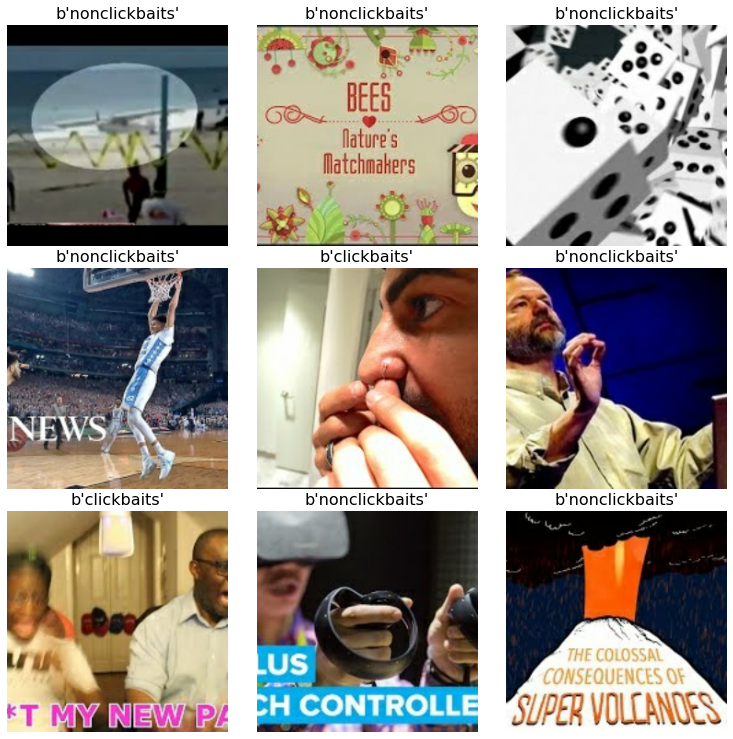

In [13]:
display_train_ds = train_ds.take(1)
display_9_images_from_batched_dataset_old(display_train_ds, CLASSES)

#Data augmentation

In [14]:
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
        preprocessing.RandomZoom(height_factor=0.1, width_factor=0.1),
    ],
    name="img_augmentation",
)

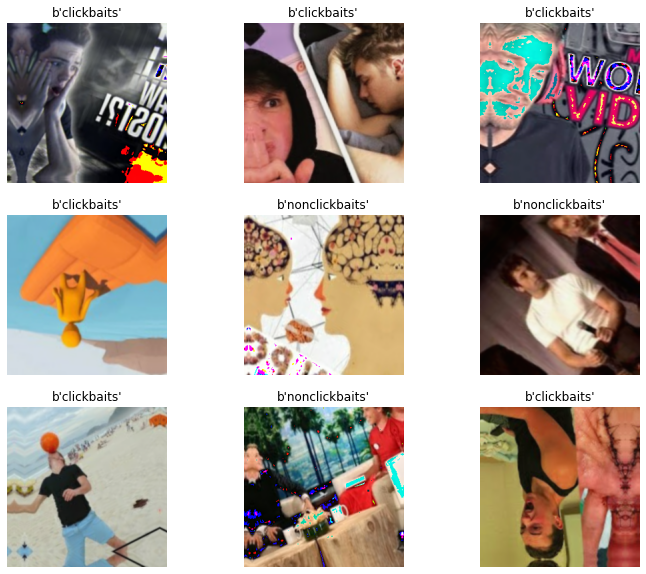

In [15]:
for image, label in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image[i], axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(CLASSES[label[i]]))
        plt.axis("off")

#Build model

##V1

In [35]:
model_builder = EffcientnetModelBuilder(IMG_SIZE=(IMG_SIZE, IMG_SIZE),
                                        weight='/content/drive/MyDrive/Colab Notebooks/efficientnetb1_notop.h5',
                                        fine_tune=False)

In [36]:
effnet_b1_v1_model = model_builder.get_model()
effnet_b1_v1_model.summary()

Model: "EfficientNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 240, 240, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, 240, 240, 3)       0         
_________________________________________________________________
efficientnetb1 (Functional)  (None, 8, 8, 1280)        6575239   
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1280)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 1280)              5120      
_________________________________________________________________
top_dropout (Dropout)        (None, 1280)              0         
_________________________________________________________________
weight_normalization_20 (Wei (None, 512)              

##V2

In [96]:
model_builder = EffcientnetModelBuilder(IMG_SIZE=(IMG_SIZE, IMG_SIZE),
                                        weight='/content/drive/MyDrive/Colab Notebooks/efficientnetb1_notop.h5', 
                                        fine_tune=True,
                                        fine_tune_at=-10,
                                        weight_normalize=False,
                                        add_regularizer=False,
                                        )

effnet_b1_v2_model = model_builder.get_model()
effnet_b1_v2_model.summary()

Model: "EfficientNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 240, 240, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, 240, 240, 3)       0         
_________________________________________________________________
efficientnetb1 (Functional)  (None, 8, 8, 1280)        6575239   
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1280)              0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 1280)              5120      
_________________________________________________________________
top_dropout (Dropout)        (None, 1280)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)              

#Training

##V1

In [37]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                        verbose=1, 
                                        patience=5, 
                                        mode='min', 
                                        restore_best_weights=True)
  
initial_learning_rate = 0.01

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=20, decay_rate=0.96, staircase=True
  )

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

effnet_b1_v1_model, effnet_b1_v1__history = mh.compile_train_model(
                                                                      effnet_b1_v1_model,
                                                                      train_ds, 
                                                                      val_ds,
                                                                      steps_per_epoch=steps_per_epoch,
                                                                      validation_steps=validation_steps,
                                                                      EPOCHS=20,
                                                                      OPTIMIZER = optimizer,
                                                                      CALLBACKS = [es],
                                                                      save_model = True,
                                                                      model_save_path = efficientNet_B1_model_path
                                                                  )

Epoch 1/20
364/364 [==============================] - 64s 149ms/step - loss: 0.6157 - tp: 3260.0603 - fp: 1532.3726 - tn: 3892.8493 - fn: 1330.6301 - accuracy: 0.7159 - precision: 0.6828 - recall: 0.7082 - auc: 0.7881 - prc: 0.7319 - val_loss: 0.4923 - val_tp: 707.0000 - val_fp: 276.0000 - val_tn: 778.0000 - val_fn: 159.0000 - val_accuracy: 0.7734 - val_precision: 0.7192 - val_recall: 0.8164 - val_auc: 0.8451 - val_prc: 0.7955
Epoch 2/20
364/364 [==============================] - 51s 140ms/step - loss: 0.5150 - tp: 1969.9973 - fp: 758.0493 - tn: 2400.4055 - fn: 727.4603 - accuracy: 0.7472 - precision: 0.7164 - recall: 0.7398 - auc: 0.8210 - prc: 0.7630 - val_loss: 0.4669 - val_tp: 620.0000 - val_fp: 172.0000 - val_tn: 882.0000 - val_fn: 246.0000 - val_accuracy: 0.7823 - val_precision: 0.7828 - val_recall: 0.7159 - val_auc: 0.8623 - val_prc: 0.8239
Epoch 3/20
364/364 [==============================] - 51s 140ms/step - loss: 0.4863 - tp: 2037.8904 - fp: 705.9616 - tn: 2458.0986 - fn: 653

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/clcikbait_detection/models/image_models/efficientNet_B1_model/assets


##V2

In [97]:
callbacks = get_callbacks(efficientNet_B1_model_weight_finetuned_path)
 
initial_learning_rate = 1e-4

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=20, decay_rate=0.50, staircase=True
  )

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

if os.path.exists(efficientNet_B1_model_weight_finetuned_path):
  print('---loading weight----')
  effnet_b1_v2_model.load_weights(efficientNet_B1_model_weight_finetuned_path)


effnet_b1_v2_model, effnet_b1_v2_history = mh.compile_train_model(
                                                                      effnet_b1_v2_model,
                                                                      train_ds, 
                                                                      val_ds,
                                                                      steps_per_epoch=steps_per_epoch,
                                                                      validation_steps=validation_steps,
                                                                      EPOCHS=50,
                                                                     #OPTIMIZER = optimizer,
                                                                      CALLBACKS = callbacks,
                                                                      save_model = True,
                                                                      model_save_path = efficientNet_B1_model_finetuned_path
                                                                  )

---loading weight----
Epoch 1/50
364/364 [==============================] - 64s 152ms/step - loss: 0.4928 - tp: 2352.9205 - fp: 815.2000 - tn: 2902.9151 - fn: 776.8767 - accuracy: 0.7678 - precision: 0.7387 - recall: 0.7556 - auc: 0.8472 - prc: 0.8128 - val_loss: 0.4307 - val_tp: 668.0000 - val_fp: 191.0000 - val_tn: 863.0000 - val_fn: 198.0000 - val_accuracy: 0.7974 - val_precision: 0.7776 - val_recall: 0.7714 - val_auc: 0.8845 - val_prc: 0.8594

Epoch 00001: val_prc improved from -inf to 0.85936, saving model to /content/drive/MyDrive/Colab Notebooks/clcikbait_detection/models/image_models/Checkpoints/efficientNet_B1_finetuned_weights.h5
Epoch 2/50
364/364 [==============================] - 52s 144ms/step - loss: 0.4187 - tp: 2114.0712 - fp: 589.8986 - tn: 2574.1452 - fn: 577.7973 - accuracy: 0.8024 - precision: 0.7832 - recall: 0.7824 - auc: 0.8880 - prc: 0.8657 - val_loss: 0.4412 - val_tp: 733.0000 - val_fp: 263.0000 - val_tn: 791.0000 - val_fn: 133.0000 - val_accuracy: 0.7937 - va

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/clcikbait_detection/models/image_models/efficientNet_B1_finetuned_model/assets


#Plot training history

###V1

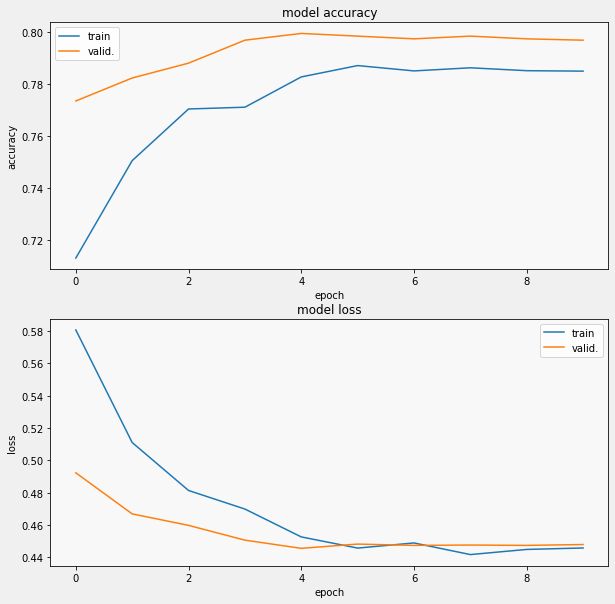

In [40]:
vh.display_training_curves(effnet_b1_v1__history.history['accuracy'], effnet_b1_v1__history.history['val_accuracy'], 'accuracy', 211)
vh.display_training_curves(effnet_b1_v1__history.history['loss'], effnet_b1_v1__history.history['val_loss'], 'loss', 212)

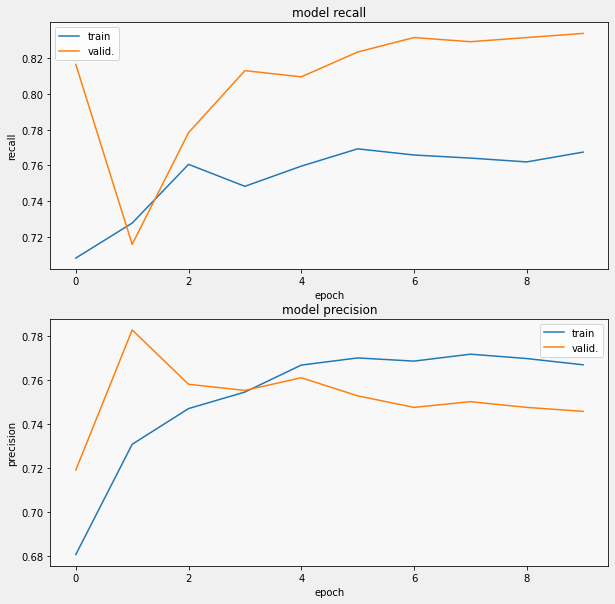

In [41]:
vh.display_training_curves(effnet_b1_v1__history.history['recall'], effnet_b1_v1__history.history['val_recall'], 'recall', 211)
vh.display_training_curves(effnet_b1_v1__history.history['precision'], effnet_b1_v1__history.history['val_precision'], 'precision', 212)

##V2

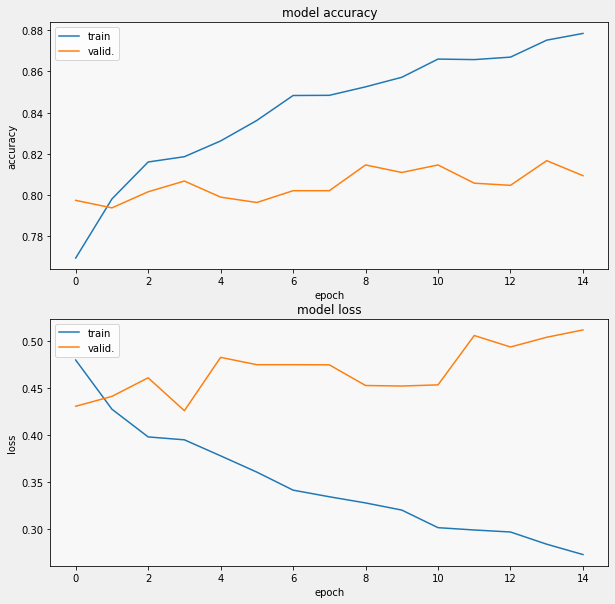

In [98]:
vh.display_training_curves(effnet_b1_v2_history.history['accuracy'], effnet_b1_v2_history.history['val_accuracy'], 'accuracy', 211)
vh.display_training_curves(effnet_b1_v2_history.history['loss'], effnet_b1_v2_history.history['val_loss'], 'loss', 212)

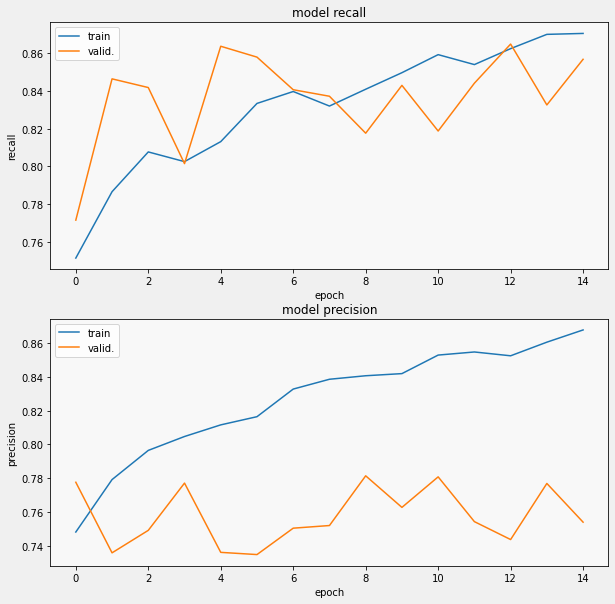

In [99]:
vh.display_training_curves(effnet_b1_v2_history.history['recall'], effnet_b1_v2_history.history['val_recall'], 'recall', 211)
vh.display_training_curves(effnet_b1_v2_history.history['precision'], effnet_b1_v2_history.history['val_precision'], 'precision', 212)

#Model evaluation and Predictions

###V1

61/61 [==============================] - 7s 114ms/step - loss: 0.4405 - tp: 709.0000 - fp: 212.0000 - tn: 840.0000 - fn: 187.0000 - accuracy: 0.7952 - precision: 0.7698 - recall: 0.7913 - auc: 0.8808 - prc: 0.8630
loss :  0.4405246675014496
tp :  709.0
fp :  212.0
tn :  840.0
fn :  187.0
accuracy :  0.7951745390892029
precision :  0.7698154449462891
recall :  0.7912946343421936
auc :  0.8808099627494812
prc :  0.8629790544509888



Accuracy: 0.778125
Precision: 0.735683
Recall: 0.782201
F1 score: 0.758229
ROC AUC: 0.778530
[[413 120]
 [ 93 334]]
Non clickbaits Detected (True Negatives):  413
Non-Clickbaits Detected as Clickbaits (False Positives):  120
Clickbaits Detected as Non-clickbaits (False Negatives):  93
Clickbaits Detected (True Positives):  334
Total Non-clickbaits:  533
Total Clickbaits:  427



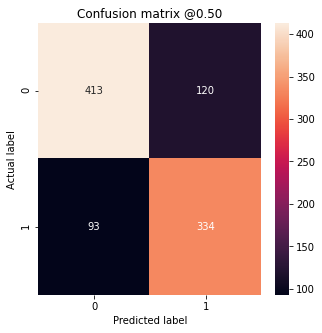

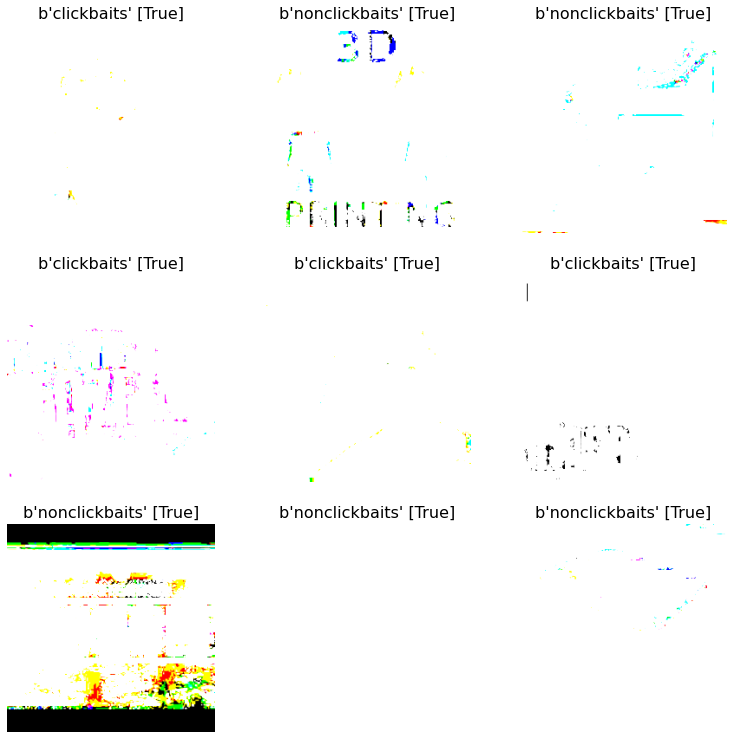

In [44]:
#saved_model_efficientNet_b1_v1 = keras.models.load_model(efficientNet_B1_model_path)
results = effnet_b1_v1_model.evaluate(test_ds)

for name, value in zip(effnet_b1_v1_model.metrics_names, results):
  print(name, ': ', value)
print()

test_image, y_true, y_pred, predicted_scores = mh.predict_on_test_vis(effnet_b1_v1_model, test_ds, BATCH_SIZE=BATCH_SIZE, N=30)
vh.display_9_images_with_predictions(test_image[30:], y_pred[30:], y_true[30:], CLASSES=CLASSES)

##V2

61/61 [==============================] - 7s 121ms/step - loss: 0.3971 - tp: 752.0000 - fp: 191.0000 - tn: 861.0000 - fn: 144.0000 - accuracy: 0.8280 - precision: 0.7975 - recall: 0.8393 - auc: 0.9152 - prc: 0.9051
loss :  0.3970740735530853
tp :  752.0
fp :  191.0
tn :  861.0
fn :  144.0
accuracy :  0.8280287384986877
precision :  0.7974549531936646
recall :  0.8392857313156128
auc :  0.9152194261550903
prc :  0.9050559997558594



Accuracy: 0.822917
Precision: 0.782418
Recall: 0.833724
F1 score: 0.807256
ROC AUC: 0.823991
[[434  99]
 [ 71 356]]
Non clickbaits Detected (True Negatives):  434
Non-Clickbaits Detected as Clickbaits (False Positives):  99
Clickbaits Detected as Non-clickbaits (False Negatives):  71
Clickbaits Detected (True Positives):  356
Total Non-clickbaits:  533
Total Clickbaits:  427



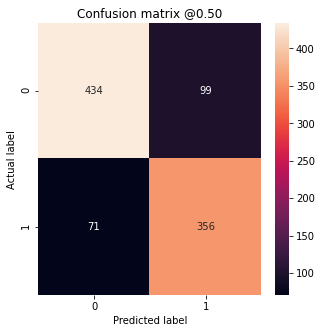

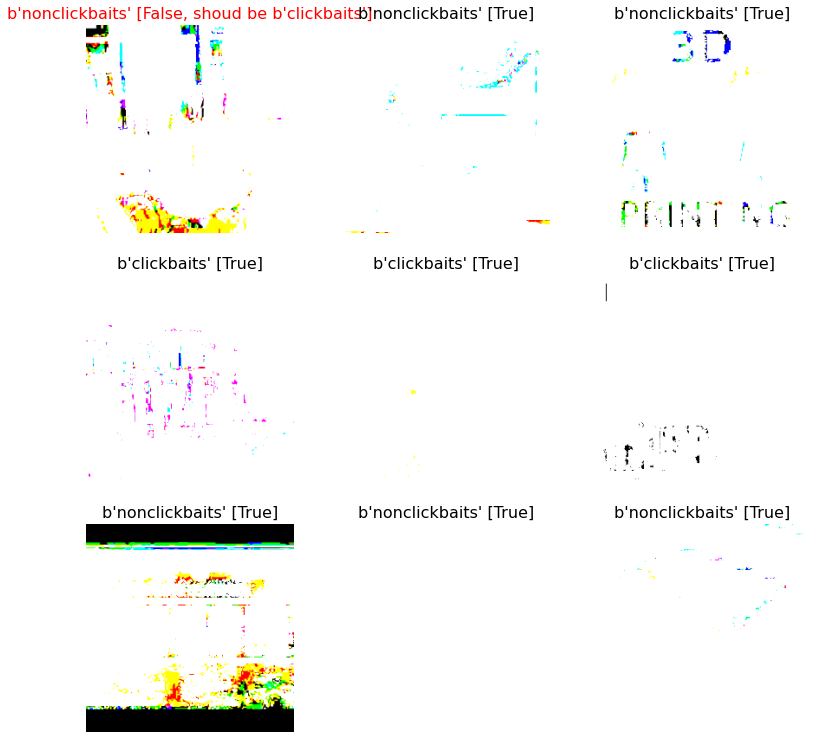

In [100]:
#saved_model_efficientNet_b1_v2 = keras.models.load_model(efficientNet_B1_model_finetuned_path)
results = effnet_b1_v2_model.evaluate(test_ds)

for name, value in zip(effnet_b1_v2_model.metrics_names, results):
  print(name, ': ', value)
print()

test_image, y_true, y_pred, predicted_scores = mh.predict_on_test_vis(effnet_b1_v2_model, test_ds, BATCH_SIZE=BATCH_SIZE, N=30)
vh.display_9_images_with_predictions(test_image[30:], y_pred[30:], y_true[30:], CLASSES=CLASSES)